Dengue cases in the city of Sao Paulo: analysis

In [1]:
import pathlib
from io import StringIO

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from epiweeks import Week

import warnings
warnings.filterwarnings("ignore", category=(RuntimeWarning or FutureWarning))

In [2]:
def preprocess_dengue_data(files_path):
    # Initialize an empty dictionary to store processed data
    dengue_dict = {}

    # Iterate over all CSV files in the specified path
    for csv in files_path.iterdir():
        # Open the current CSV file in read mode with Latin-1 encoding
        with open(files_path / csv.name, 'r', encoding='latin-1') as file:
            # Read the entire content of the file into a string
            content = file.read()

        # Find the start index of the actual data (after the header)
        data_start = content.index('"Class. Final"')

        # Find the end index of the data (before the footer)/drop
        data_finish = content.index("Fonte: Ministério da Saúde/SVSA - Sistema de Informação de Agravos de Notificação - Sinan Net")

        # Extract the relevant part of the content (data only)
        data_content = content[data_start:data_finish]

        # Create a file-like object from the extracted data
        data_io = StringIO(data_content)

        # Read the extracted data into a Pandas DataFrame using Latin-1 encoding and semicolon as separator
        dengue_dict[csv.name.rsplit('_')[1].split('.')[0]] = pd.read_csv(data_io, sep=';', encoding='latin-1')

    # Concatenate all DataFrames in the dictionary into a single one
    df = pd.concat(dengue_dict.values(), keys=dengue_dict.keys())

    # Reset index and rename level_0 to 'Year'
    df = df.reset_index(level=0).rename(columns={'level_0': 'Year'})

    # Drop unwanted column 'Em Branco/ign'
    df = df.drop(['Em Branco/ign'], axis=1)

    # Pivot the DataFrame into a wide format (default is long)
    df = df.melt(id_vars=['Class. Final', 'Year'], var_name='Week', value_name='Cases')

    # Filter rows where 'Class. Final' equals 'Total'
    df = df[df['Class. Final'] == 'Total']

    # Sort the DataFrame by 'Year' and 'Week'
    df = df.sort_values(['Year', 'Week']).reset_index(drop=True)

    # Create a new column 'Total' with default values (will be filled later)
    df['Total'] = pd.Series()

    # Iterate over unique years in the DataFrame
    for year in df.Year.unique():
        # Replace week strings with full dates (e.g., 'Semana 1' becomes '2020-01-13')
        df.loc[(df['Year'] == year), 'Week'] = df.loc[(df['Year'] == year), 'Week'].apply(lambda x: x.replace("Semana ", year))

        # Fill the 'Total' column with values from 'Cases' column for each year
        df.loc[df['Year'] == year, 'Total'] = df['Cases'].loc[(df['Year'] == year) & (df['Week'] == 'Total')]

    # Backfill NaN values in the 'Total' column
    df['Total'] = df['Total'].bfill()

    # Find indices of rows where 'Week' equals 'Total'
    index_delete = df.loc[df['Week'] == 'Total'].index

    # Drop these rows and reset index
    df = df.dropna()
    df = df.drop(index_delete).reset_index(drop=True)

    # Extract start dates from week strings using the Week.fromstring function
    df['Start_Week'] = df['Week'].apply(lambda x: Week.fromstring(x, validate=False).startdate())

    # Convert 'Start_Week' column to datetime format
    df['Start_Week'] = pd.to_datetime(arg=df['Start_Week'], format='%Y%M%d')

    # Extract end dates from week strings using the Week.fromstring function
    df['End_Week'] = df['Week'].apply(lambda x: Week.fromstring(x, validate=False).enddate())

    # Convert 'End_Week' column to datetime format
    df['End_Week'] = pd.to_datetime(arg=df['End_Week'], format='%Y%M%d')
    
    return df

# Import dengue CSV files from a specified path
path_dengue = pathlib.Path('../data/dengue/epi_week')
dengue_df = preprocess_dengue_data(path_dengue)

/tmp/ipykernel_28467/487115078.py:57: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['Total'] = df['Total'].bfill()


In [3]:
# Define a function to preprocess climate data from CSV files
def preprocess_climate_data(files_path):
    
    # Define a helper function to format 'Hora' column values as 4-digit strings
    def format_hora(x: str):
        if x == '0':
            return '0000'
        else:
            return x

    # Initialize an empty list to store DataFrames from each file
    dfs = []

    # Iterate over the files in the specified directory
    for file in files_path.iterdir():
        
        # Read the CSV file into a DataFrame using pandas
        climate_df = pd.read_csv(files_path / file.name, sep=';', decimal=',')
        
        # Format the 'Data' and 'Hora (UTC)' columns to create a datetime column
        climate_df['Date'] = pd.to_datetime(climate_df['Data'] + ' ' + climate_df['Hora (UTC)'].astype('str').apply(format_hora), format='%d/%m/%Y %H%M')
        
        # Set the 'Date' column as the index of the DataFrame
        climate_df.set_index("Date", inplace=True)
        
        # Drop the original date and time columns from the DataFrame
        climate_df.drop(['Data', 'Hora (UTC)'], inplace=True, axis=1)
        
        # Resample the data daily and calculate the mean values
        climate_daily_df = climate_df.resample('D').mean()
        
        # Append the resulting DataFrame to the list
        dfs.append(climate_daily_df)
        
    # Concatenate all the DataFrames in the list into a single DataFrame
    climate_data = pd.concat(dfs)
        
    # Sort the index of the concatenated DataFrame
    climate_data.sort_index(inplace=True)
    
    return climate_data

# Importing climate CSV files from the specified directory
path_climate = pathlib.Path('../data/climate/')

# Preprocess the climate data and store it in a variable called `climate_data`
climate_data = preprocess_climate_data(path_climate)

In [4]:
# Function to merge dengue and climate dataframes
def merge_dfs(dengue, climate):
    # Initialize an empty list to store the merged data
    result = []
    
    # Iterate over each row in the dengue dataframe
    for _, row in dengue.iterrows():
        # Extract climate data for the corresponding week
        week_data = climate.loc[row['Start_Week']:row['End_Week']]
        
        # Calculate the mean of the climate data for the week
        week_avg = week_data.mean()
        
        # Merge the dengue row with the average climate data and append to the result list
        result.append(pd.concat([row, week_avg]))
    
    # Convert the result list to a dataframe, using the 'End_Week' column as the index
    result_df = pd.DataFrame(result, index=dengue['End_Week'])
    
    # Drop unnecessary columns from the result dataframe
    result_df.drop(['Class. Final', 'Year', 'Week', 'Start_Week', 'End_Week'], axis=1, inplace=True)
    
    # Rename the columns of the result dataframe
    result_df.columns = ['Cases', 'Year_Total', 'Temp_Ins', 'Temp_Max', 'Temp_Min', 'Humidity_Ins', 'Humidity_Max', 
                            'Humidity_Min', 'DewPoint_Ins', 'DewPoint_Max', 'DewPoint_Min', 'Pressure_Ins', 
                            'Pressure_Max', 'Pressure_Min', 'WindSpeed', 'WindDirection', 'WindGust', 
                            'Radiation', 'Rainfall']
    
    # Rename the index of the result dataframe
    result_df.index.name = 'Date'
    
    # Return the final resulting DataFrame
    return result_df


In [5]:
processed_data = merge_dfs(dengue_df, climate_data)

processed_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 548 entries, 2014-01-04 to 2024-07-06
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Cases          548 non-null    object 
 1   Year_Total     548 non-null    int64  
 2   Temp_Ins       548 non-null    float64
 3   Temp_Max       548 non-null    float64
 4   Temp_Min       548 non-null    float64
 5   Humidity_Ins   548 non-null    float64
 6   Humidity_Max   548 non-null    float64
 7   Humidity_Min   548 non-null    float64
 8   DewPoint_Ins   548 non-null    float64
 9   DewPoint_Max   548 non-null    float64
 10  DewPoint_Min   548 non-null    float64
 11  Pressure_Ins   548 non-null    float64
 12  Pressure_Max   548 non-null    float64
 13  Pressure_Min   548 non-null    float64
 14  WindSpeed      538 non-null    float64
 15  WindDirection  539 non-null    float64
 16  WindGust       535 non-null    float64
 17  Radiation      547 non-null    floa

In [6]:
# Transforming 'Cases' to int
processed_data['Cases'] = processed_data['Cases'].astype(np.int64)

In [7]:
# Observing null data

null_index = processed_data[processed_data.isna().any(axis=1)].index
processed_data[processed_data.isna().any(axis=1)]

,Cases,Year_Total,Temp_Ins,Temp_Max,Temp_Min,Humidity_Ins,Humidity_Max,Humidity_Min,DewPoint_Ins,DewPoint_Max,DewPoint_Min,Pressure_Ins,Pressure_Max,Pressure_Min,WindSpeed,WindDirection,WindGust,Radiation,Rainfall
Date,,,,,,,,,,,,,,,,,,,
2014-07-26,73,31720,12.550000,12.733333,12.416667,74.500000,75.833333,74.000000,8.150000,8.483333,8.066667,933.116667,933.283333,932.983333,1.700000,120.166667,4.816667,NaN,0.000000
2021-04-17,815,7781,19.695238,20.240476,19.216071,79.458333,82.386905,76.333333,15.688095,16.249405,15.190476,928.776786,928.984524,928.587500,NaN,NaN,NaN,1247.985714,0.044048
2021-04-24,810,7781,17.619643,18.126786,17.126190,89.154762,91.964286,86.285714,15.698214,16.221429,15.253571,927.964881,928.169643,927.739286,NaN,NaN,NaN,1185.003571,0.244048
2021-05-01,646,7781,17.857143,18.316667,17.433333,85.863095,88.500000,83.065476,15.265476,15.798214,14.801786,929.567262,929.760119,929.328571,NaN,NaN,NaN,1254.463095,0.020238
2022-12-17,35,12346,20.498810,21.160119,19.941071,86.422619,90.136905,81.994048,17.810714,18.560119,17.092262,922.802976,923.038690,922.566071,2.372619,181.273810,6.188095,1486.787883,NaN
2022-12-24,39,12346,18.066071,18.484524,17.695833,95.535714,97.297619,93.226190,17.266667,17.684524,16.870238,926.188690,926.380952,925.970238,2.920833,131.125000,7.030357,1147.528571,NaN
2023-12-30,139,14702,23.110119,23.732143,22.542857,74.523810,77.839286,71.404762,17.777381,18.442857,17.254167,926.081548,926.326786,925.811310,NaN,NaN,NaN,1513.262245,0.060714
2024-01-06,944,582620,20.826569,21.328571,20.425595,84.886905,87.059524,82.285714,18.112500,18.558929,17.694048,925.729167,925.943452,925.520833,NaN,NaN,NaN,1355.161973,0.107143
2024-01-20,1873,582620,24.900000,25.613690,24.177976,78.386905,81.726190,75.232143,20.430952,21.079762,19.869643,926.052976,926.338095,925.786905,NaN,NaN,NaN,1568.756327,0.460714


In [8]:
processed_data = processed_data.ffill(axis=0)

In [9]:
# Pensar melhor se vale a pena fazer ffill ou se dropo as colunas sem serem Rainfall

processed_data.loc[null_index]

,Cases,Year_Total,Temp_Ins,Temp_Max,Temp_Min,Humidity_Ins,Humidity_Max,Humidity_Min,DewPoint_Ins,DewPoint_Max,DewPoint_Min,Pressure_Ins,Pressure_Max,Pressure_Min,WindSpeed,WindDirection,WindGust,Radiation,Rainfall
Date,,,,,,,,,,,,,,,,,,,
2014-07-26,73,31720,12.550000,12.733333,12.416667,74.500000,75.833333,74.000000,8.150000,8.483333,8.066667,933.116667,933.283333,932.983333,1.700000,120.166667,4.816667,1148.820238,0.000000
2021-04-17,815,7781,19.695238,20.240476,19.216071,79.458333,82.386905,76.333333,15.688095,16.249405,15.190476,928.776786,928.984524,928.587500,2.320328,121.621212,5.833207,1247.985714,0.044048
2021-04-24,810,7781,17.619643,18.126786,17.126190,89.154762,91.964286,86.285714,15.698214,16.221429,15.253571,927.964881,928.169643,927.739286,2.320328,121.621212,5.833207,1185.003571,0.244048
2021-05-01,646,7781,17.857143,18.316667,17.433333,85.863095,88.500000,83.065476,15.265476,15.798214,14.801786,929.567262,929.760119,929.328571,2.320328,121.621212,5.833207,1254.463095,0.020238
2022-12-17,35,12346,20.498810,21.160119,19.941071,86.422619,90.136905,81.994048,17.810714,18.560119,17.092262,922.802976,923.038690,922.566071,2.372619,181.273810,6.188095,1486.787883,0.455000
2022-12-24,39,12346,18.066071,18.484524,17.695833,95.535714,97.297619,93.226190,17.266667,17.684524,16.870238,926.188690,926.380952,925.970238,2.920833,131.125000,7.030357,1147.528571,0.455000
2023-12-30,139,14702,23.110119,23.732143,22.542857,74.523810,77.839286,71.404762,17.777381,18.442857,17.254167,926.081548,926.326786,925.811310,1.716667,107.500000,4.616667,1513.262245,0.060714
2024-01-06,944,582620,20.826569,21.328571,20.425595,84.886905,87.059524,82.285714,18.112500,18.558929,17.694048,925.729167,925.943452,925.520833,1.716667,107.500000,4.616667,1355.161973,0.107143
2024-01-20,1873,582620,24.900000,25.613690,24.177976,78.386905,81.726190,75.232143,20.430952,21.079762,19.869643,926.052976,926.338095,925.786905,2.533333,261.666667,4.350000,1568.756327,0.460714


In [10]:
# Separating 2024 data
df_2024 = processed_data[processed_data.index.year == 2024]
df_2014_2023 = processed_data.drop(df_2024.index)

In [11]:
df_2024.shape

(27, 19)

In [12]:
df_2014_2023.shape

(521, 19)

In [13]:
# df_2024.to_csv("df_2024")
# df_2014_2023.to_csv("df_2014_2023")

In [14]:
# 2. Create a time series object
ts_cases = df_2014_2023['Cases']

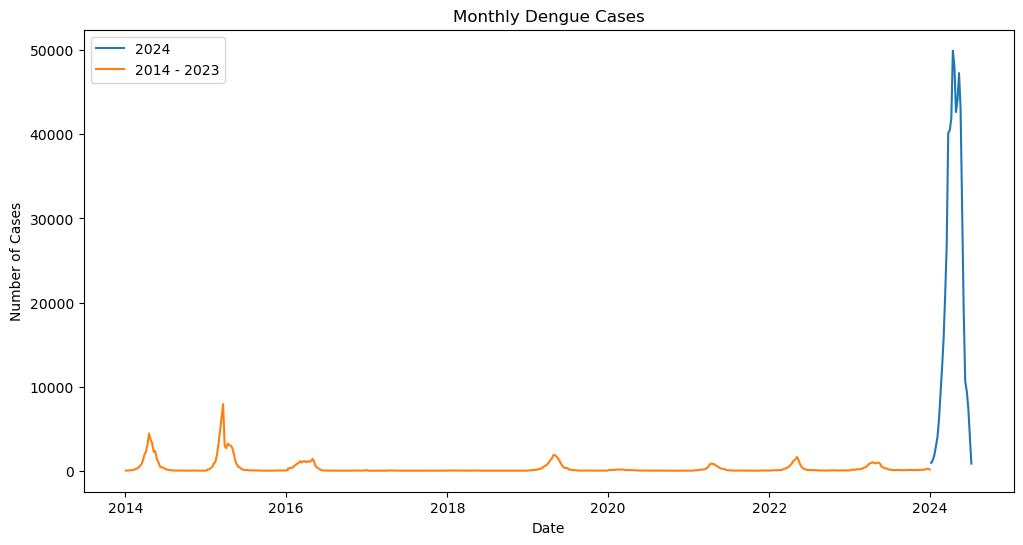

In [15]:
# 3. Visualize the time series data
plt.figure(figsize=(12, 6))
plt.plot(df_2024['Cases'], label = '2024')
plt.plot(ts_cases, label = "2014 - 2023")
plt.legend(loc="upper left")
plt.title('Monthly Dengue Cases')
plt.xlabel('Date')
plt.ylabel('Number of Cases')
plt.show()

### Time series analysis

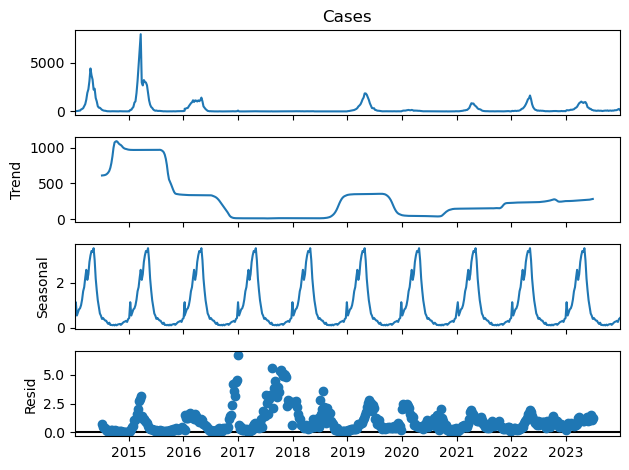

In [16]:
# 4. Analyze seasonality and trends
result = seasonal_decompose(ts_cases, model='multiplicative', period=52)
result.plot()
plt.tight_layout()
plt.show()

In [17]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(ts_cases)
print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values:', result[4])
print('Non-stationary data' if result[1] > 0.05 else 'Stationary data')

ADF Statistic: -6.198550029026893
p-value: 5.883524436880551e-08
Critical Values: {'1%': -3.443136494643789, '5%': -2.8671794725841147, '10%': -2.5697736283668187}
Stationary data


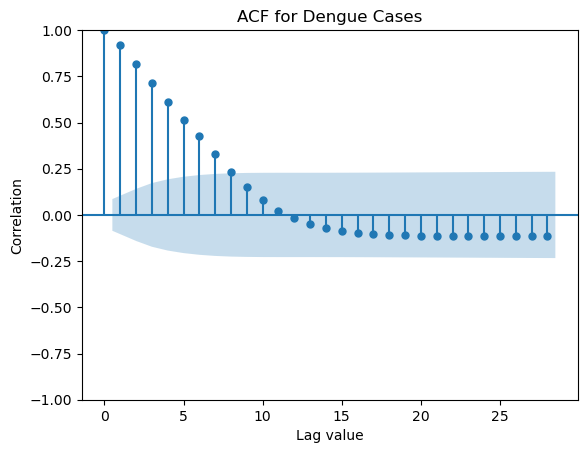

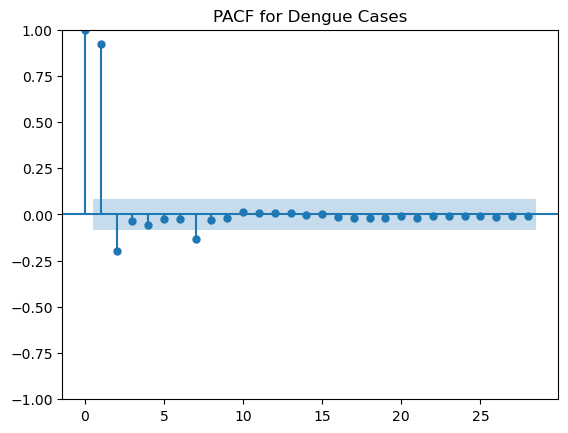

In [18]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_cases)
plt.title('ACF for Dengue Cases')
plt.ylabel('Correlation')
plt.xlabel('Lag value')
plt.show()

plot_pacf(ts_cases)
plt.title('PACF for Dengue Cases')
plt.show()

### Feature Engineering

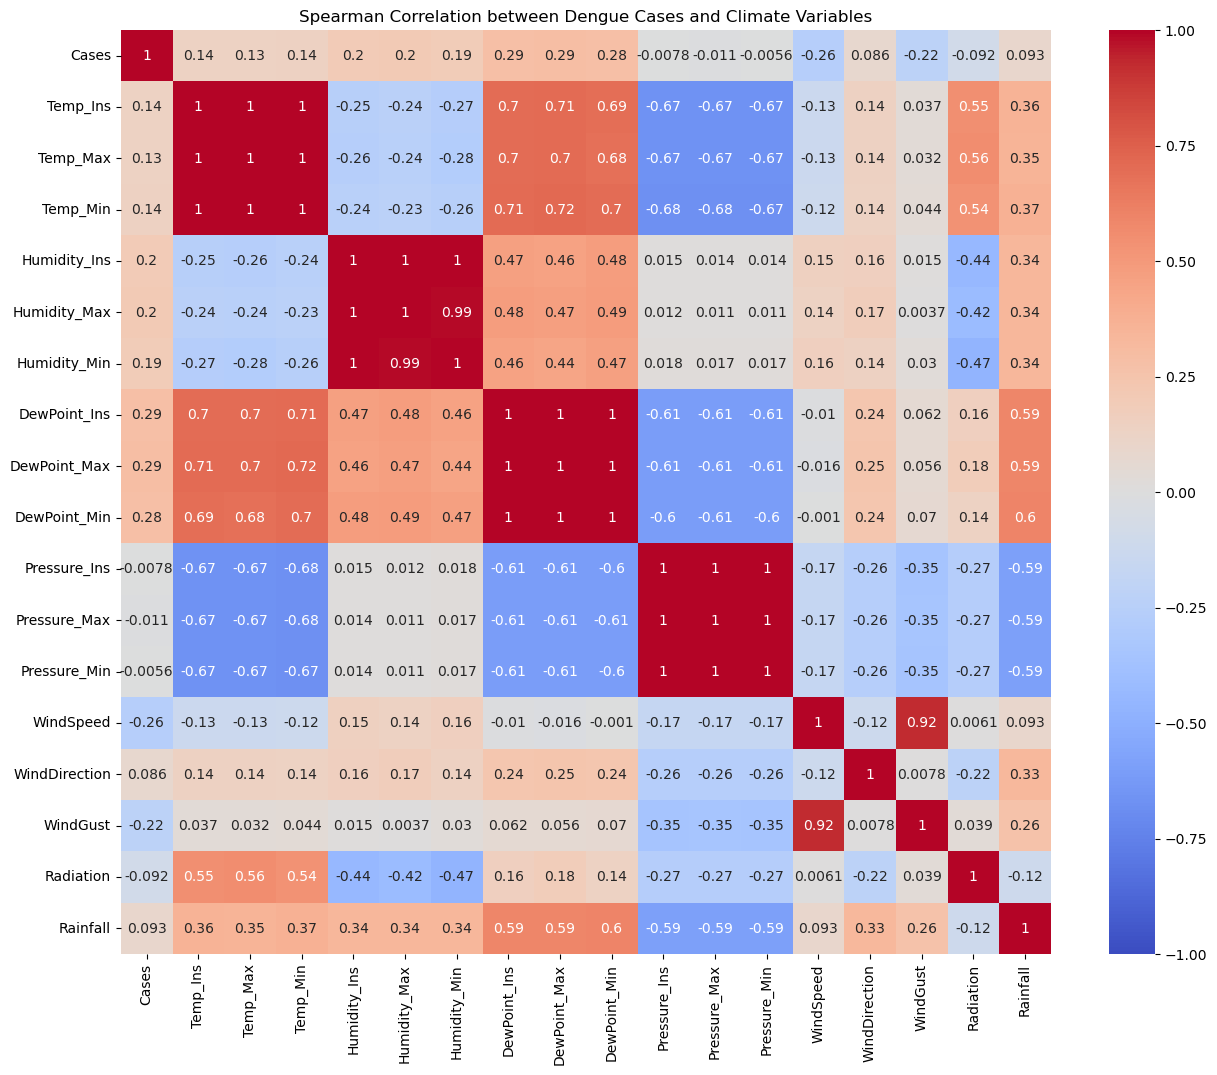

In [19]:
# 5. Correlate climate variables with dengue cases using Spearman' correlation coeficient 
climate_vars = df_2014_2023.columns[2:]
correlation_matrix = df_2014_2023[['Cases' , *climate_vars]].corr(method='spearman')

plt.figure(figsize=(15, 12))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0)
plt.title('Spearman Correlation between Dengue Cases and Climate Variables')
plt.show()

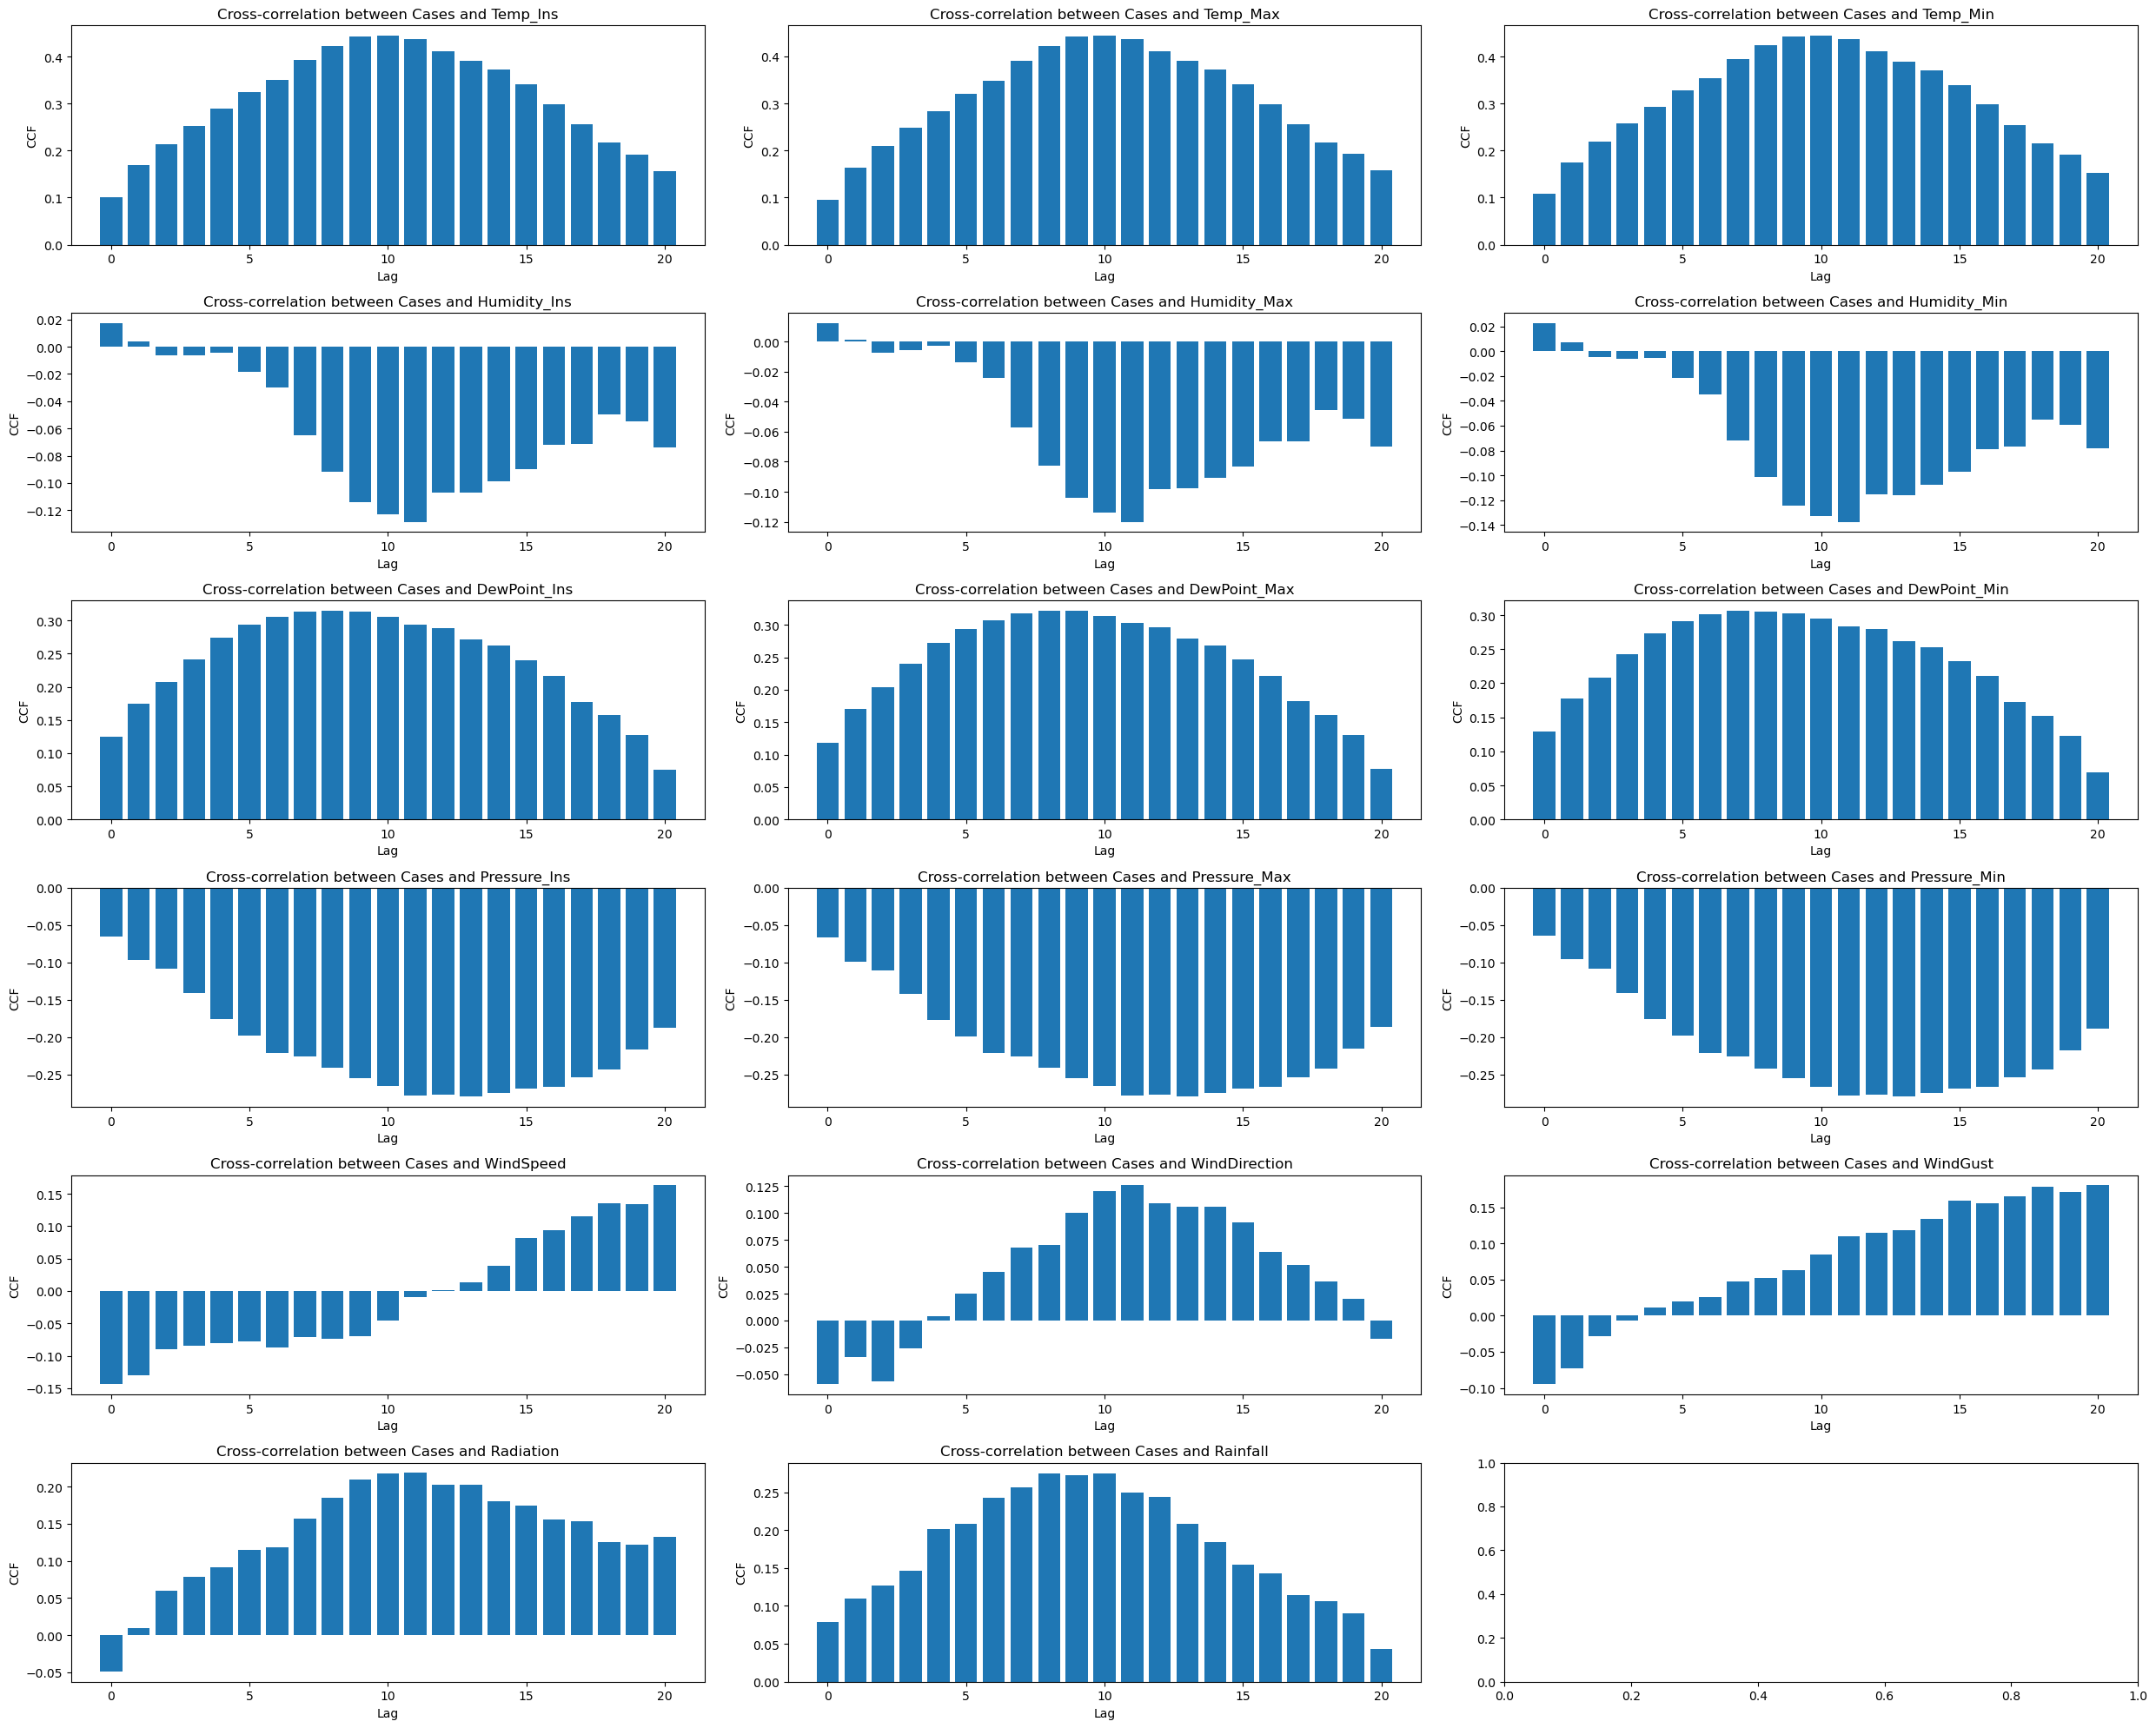

In [20]:
from statsmodels.tsa.stattools import ccf

def plot_ccf(x, y,  variables, lags=20):
    _ , axes = plt.subplots(ncols=3, nrows=round(len(variables)/3), figsize = (25, 20))
    for i, var in enumerate(variables):
        ax = axes[i // 3, i % 3]
        ccf_values = ccf(x, y[var], adjusted=False)[:lags+1]
        ax.bar(range(lags+1), ccf_values)
        ax.set_title(f'Cross-correlation between {x.name} and {var}')
        ax.set_xlabel('Lag')
        ax.set_ylabel('CCF')
    plt.tight_layout()
    plt.show()

variables = ['Temp_Ins', 'Temp_Max', 'Temp_Min',
       'Humidity_Ins', 'Humidity_Max', 'Humidity_Min', 'DewPoint_Ins',
       'DewPoint_Max', 'DewPoint_Min', 'Pressure_Ins', 'Pressure_Max',
       'Pressure_Min', 'WindSpeed', 'WindDirection', 'WindGust', 'Radiation',
       'Rainfall']

plot_ccf(df_2014_2023['Cases'], df_2014_2023, variables = variables)

In [21]:
def add_lagged_features(initial_df, target_col='Cases', max_lag=20, ccf_threshold=0.25):
    df = initial_df.copy()
    features = ['Temp_Ins', 'Temp_Max', 'Temp_Min', 'Humidity_Ins', 'Humidity_Max', 'Humidity_Min',
                'DewPoint_Ins', 'DewPoint_Max', 'DewPoint_Min', 'Pressure_Ins', 'Pressure_Max', 'Pressure_Min',
                'WindSpeed', 'WindDirection', 'WindGust', 'Radiation', 'Rainfall']
    
    def get_relevant_lags(series, target):
        ccf_values = ccf(target, series, adjusted=False)[1:]  # Exclude lag 0
        abs_ccf = np.abs(ccf_values)
        
        # Apply CCF threshold
        significant_lags = np.where(abs_ccf >= ccf_threshold)[0] + 1
        # print(significant_lags)
        
        if len(significant_lags) == 0:
            return []
        
        if series.name.startswith(('Temp', 'DewPoint', 'WindDirection', 'Radiation', 'Rainfall')):
            lags = [lag for lag in [8, 10, 12] if lag in significant_lags]
        elif series.name.startswith('Humidity'):
            lags = [lag for lag in [8, 10, 12] if lag in significant_lags]
        elif series.name.startswith('Pressure'):
            lags = [lag for lag in [10, 15, 20] if lag in significant_lags]
        elif series.name in ['WindSpeed', 'WindGust']:
            lags = [lag for lag in [12, 16, 20] if lag in significant_lags]
        else:
            # If not specified, use top 3 significant lags
            lags = sorted(significant_lags)[:3]
        
        return lags
    
    for feature in features:
        lags = get_relevant_lags(df[feature], df[target_col])
        for lag in lags:
            df[f'{feature}_lag_{lag}'] = df[feature].shift(lag)
    
    return df.dropna()

In [22]:
processed_data.shape

(548, 19)

In [23]:
df_shifted = add_lagged_features(df_2014_2023) 

In [24]:
df_shifted.shape

(506, 45)

In [25]:
df_shifted.columns

Index(['Cases', 'Year_Total', 'Temp_Ins', 'Temp_Max', 'Temp_Min',
       'Humidity_Ins', 'Humidity_Max', 'Humidity_Min', 'DewPoint_Ins',
       'DewPoint_Max', 'DewPoint_Min', 'Pressure_Ins', 'Pressure_Max',
       'Pressure_Min', 'WindSpeed', 'WindDirection', 'WindGust', 'Radiation',
       'Rainfall', 'Temp_Ins_lag_8', 'Temp_Ins_lag_10', 'Temp_Ins_lag_12',
       'Temp_Max_lag_8', 'Temp_Max_lag_10', 'Temp_Max_lag_12',
       'Temp_Min_lag_8', 'Temp_Min_lag_10', 'Temp_Min_lag_12',
       'DewPoint_Ins_lag_8', 'DewPoint_Ins_lag_10', 'DewPoint_Ins_lag_12',
       'DewPoint_Max_lag_8', 'DewPoint_Max_lag_10', 'DewPoint_Max_lag_12',
       'DewPoint_Min_lag_8', 'DewPoint_Min_lag_10', 'DewPoint_Min_lag_12',
       'Pressure_Ins_lag_10', 'Pressure_Ins_lag_15', 'Pressure_Max_lag_10',
       'Pressure_Max_lag_15', 'Pressure_Min_lag_10', 'Pressure_Min_lag_15',
       'Rainfall_lag_8', 'Rainfall_lag_10'],
      dtype='object')

### Feature Selection

In [26]:
X = df_shifted.drop(['Cases', 'Year_Total'], axis=1)
y = df_shifted['Cases']

In [27]:
from boruta import BorutaPy
from sklearn.ensemble import RandomForestRegressor

def perform_boruta(X, y):
    # Addressing errors
    np.int = np.int64
    np.float = np.float64
    np.bool = np.bool_
    # Initialize Boruta
    rf = RandomForestRegressor(n_jobs=-1, max_depth=5)
    boruta = BorutaPy(rf, n_estimators='auto', verbose=2, random_state=42)
    
    # Fit Boruta
    boruta.fit(np.array(X), np.array(y))
    
    # Get results
    boruta_results = pd.DataFrame({
        'Feature': X.columns,
        'Importance': boruta.ranking_,
        'Selected': boruta.support_
    })
    
    return boruta_results.sort_values('Importance')



In [28]:

# Usage
boruta_results = perform_boruta(X, y)
print(boruta_results)

# Get selected features
boruta_features = boruta_results[boruta_results['Selected']]['Feature'].tolist()


Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	43
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	43
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	43
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	43
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	43
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	43
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	43
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	0
Tentative: 	11
Rejected: 	32
Iteration: 	9 / 100
Confirmed: 	0
Tentative: 	11
Rejected: 	32
Iteration: 	10 / 100
Confirmed: 	0
Tentative: 	11
Rejected: 	32
Iteration: 	11 / 100
Confirmed: 	0
Tentative: 	11
Rejected: 	32
Iteration: 	12 / 100
Confirmed: 	0
Tentative: 	11
Rejected: 	32
Iteration: 	13 / 100
Confirmed: 	0
Tentative: 	11
Rejected: 	32
Iteration: 	14 / 100
Confirmed: 	0
Tentative: 	11
Rejected: 	32
Iteration: 	15 / 100
Confirmed: 	0
Tentative: 	11
Rejected: 	32
Iteration: 	16 / 100
Confirmed: 	2
Tentative: 	9
Rejecte

In [29]:
from statsmodels.tsa.stattools import grangercausalitytests

def calc_granger(X, y):
    imp_var = []
    for var in X.columns:
        data = pd.concat([y, X[var]], axis=1).dropna()
        result = grangercausalitytests(data, maxlag=5, verbose=False)
        if result[1][0]['ssr_ftest'][1] < 0.05:
            print(f"Granger causality p-value for {var}: {result[1][0]['ssr_ftest'][1]}")
            imp_var.append(var)
    return imp_var

In [30]:
granger_significant = calc_granger(X, y)

Granger causality p-value for Temp_Ins: 4.3435420536618204e-05
Granger causality p-value for Temp_Max: 4.1975258234419746e-05
Granger causality p-value for Temp_Min: 4.416023768927955e-05
Granger causality p-value for DewPoint_Ins: 0.000633575865897195
Granger causality p-value for DewPoint_Max: 0.0005253686968064639
Granger causality p-value for DewPoint_Min: 0.0007989327566909667
Granger causality p-value for Pressure_Ins: 0.049662923554647125
Granger causality p-value for Pressure_Max: 0.049250570553546605
Granger causality p-value for Radiation: 0.0045242685590678785
Granger causality p-value for Rainfall: 0.007868236418457665
Granger causality p-value for Temp_Ins_lag_8: 0.0064204086465512
Granger causality p-value for Temp_Max_lag_8: 0.006086879285338251
Granger causality p-value for Temp_Min_lag_8: 0.006941399065745867
Granger causality p-value for Pressure_Ins_lag_10: 0.027959250577467048
Granger causality p-value for Pressure_Max_lag_10: 0.027420875870325264
Granger causality 

In [31]:
from sklearn.model_selection import train_test_split

def get_rf_importance(X, y):

    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Train the model
    rf = RandomForestRegressor(n_estimators=100, random_state=42)
    rf.fit(X_train, y_train)

    # Get feature importances
    importances = pd.DataFrame({'feature': X.columns, 'importance': rf.feature_importances_})
    importances = importances.sort_values('importance', ascending=False).set_index('feature', drop=True)

    return importances



In [32]:
rf_importance = get_rf_importance(X, y)
rf_importance

,importance
feature,
Temp_Min_lag_8,0.116823
Temp_Ins_lag_10,0.106887
Temp_Max_lag_10,0.073330
Temp_Max_lag_8,0.067384
Temp_Min_lag_10,0.065968
Temp_Min_lag_12,0.052998
Rainfall_lag_8,0.046360
Temp_Ins_lag_12,0.042962
Temp_Ins_lag_8,0.038393


In [33]:
from sklearn.preprocessing import RobustScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.feature_selection import mutual_info_regression


def calculate_vif(X):
    vif_data = pd.DataFrame()
    vif_data["feature"] = X.columns
    vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    return vif_data.sort_values('VIF', ascending=False).set_index('feature', drop=True)

# Calculate Mutual Information
def get_mutual_info(X, y):
    scaler = RobustScaler()
    X_scaled = scaler.fit_transform(X)
    mi = mutual_info_regression(X_scaled, y)
    mi_scores = pd.Series(mi, index=X.columns).sort_values(ascending=False)
    return  mi_scores



In [34]:
# VIF
vif_results = calculate_vif(X)
# print("VIF Results:")
# print(vif_results)

In [35]:
# MI
mi_scores = get_mutual_info(X, y)

In [36]:
def feature_ensemble_score(X_, boruta_selected, granger_significant, rf_importance, vif_results, mi_scores):
    X = X_.copy()
    
    scores = pd.DataFrame(index=X.columns, columns=['Score'])
    scores['Score'] = 0
    
    # Boruta (2 points for selected features)
    scores.loc[boruta_selected, 'Score'] += 2
    
    # Granger causality (1 point)
    scores.loc[granger_significant, 'Score'] += 1
    
    # Random Forest importance (2 points for top 5, 1 for next 10)
    scores.loc[rf_importance.index[:5], 'Score'] += 2
    scores.loc[rf_importance.index[5:15], 'Score'] += 1
    
    # VIF (subtract 2 points for VIF > 10, 1 point for VIF > 5)
    high_vif_features = vif_results[vif_results['VIF'] > 10].index
    scores.loc[high_vif_features, 'Score'] -= 2
    medium_vif_features = vif_results[(vif_results['VIF'] > 5) & (vif_results['VIF'] <= 10)].index
    scores.loc[medium_vif_features, 'Score'] -= 1
    
   # Mutual Information (2 points for top 5, 1 for next 10)
    scores.loc[mi_scores.index[:5], 'Score'] += 2
    scores.loc[mi_scores.index[5:15], 'Score'] += 1
    
    return scores.sort_values('Score', ascending=False)

In [37]:
# Create strongly filtered dataset by selecting features using Boruta
X_strong = X[boruta_features]

# Keep weakly filtered dataset (all features)
X_weak = X

# Apply Granger causality analysis on both datasets
granger_significant_strong = calc_granger(X_strong, y) 
granger_significant_weak = calc_granger(X_weak, y)

# Calculate Variance Inflation Factor (VIF) for both datasets
vif_results_strong = calculate_vif(X_strong)
vif_results_weak = calculate_vif(X_weak)

# Get Random Forest feature importance scores for both datasets
rf_importance_strong = get_rf_importance(X_strong, y)
rf_importance_weak = get_rf_importance(X_weak, y)

# Calculate mutual information scores for both datasets
mi_scores_strong = get_mutual_info(X_strong, y)
mi_scores_weak = get_mutual_info(X_weak, y)

# Ensemble score calculation for strongly filtered dataset
ensemble_scores_strong = feature_ensemble_score(X_strong, boruta_features, granger_significant_strong, 
                                                rf_importance_strong, vif_results_strong, mi_scores_strong)

# Ensemble score calculation for weakly filtered dataset
ensemble_scores_weak = feature_ensemble_score(X_weak, boruta_features, granger_significant_weak, 
                                              rf_importance_weak, vif_results_weak, mi_scores_weak)

# Compare the results of ensemble scores from both datasets
print("Strongly filtered results:")
print(ensemble_scores_strong)
print("\nWeakly filtered results:")
print(ensemble_scores_weak)

Granger causality p-value for Temp_Min_lag_8: 0.006941399065745867
Granger causality p-value for Temp_Max_lag_8: 0.006086879285338251
Granger causality p-value for Temp_Ins_lag_8: 0.0064204086465512
Granger causality p-value for Temp_Ins: 4.3435420536618204e-05
Granger causality p-value for Temp_Max: 4.1975258234419746e-05
Granger causality p-value for Temp_Min: 4.416023768927955e-05
Granger causality p-value for DewPoint_Ins: 0.000633575865897195
Granger causality p-value for DewPoint_Max: 0.0005253686968064639
Granger causality p-value for DewPoint_Min: 0.0007989327566909667
Granger causality p-value for Pressure_Ins: 0.049662923554647125
Granger causality p-value for Pressure_Max: 0.049250570553546605
Granger causality p-value for Radiation: 0.0045242685590678785
Granger causality p-value for Rainfall: 0.007868236418457665
Granger causality p-value for Temp_Ins_lag_8: 0.0064204086465512
Granger causality p-value for Temp_Max_lag_8: 0.006086879285338251
Granger causality p-value for 

In [38]:
def create_lag_features_2024(df_):
    df = df_.copy()
    for n, col in enumerate(['Temp_Ins_lag_8',
       'Temp_Ins_lag_10', 'Temp_Ins_lag_12', 'Temp_Max_lag_8',
       'Temp_Max_lag_10', 'Temp_Max_lag_12', 'Temp_Min_lag_8',
       'Temp_Min_lag_10', 'Temp_Min_lag_12', 'DewPoint_Ins_lag_8',
       'DewPoint_Ins_lag_10', 'DewPoint_Ins_lag_12', 'DewPoint_Max_lag_8',
       'DewPoint_Max_lag_10', 'DewPoint_Max_lag_12', 'DewPoint_Min_lag_8',
       'DewPoint_Min_lag_10', 'DewPoint_Min_lag_12', 'Pressure_Ins_lag_10',
       'Pressure_Ins_lag_15', 'Pressure_Max_lag_10', 'Pressure_Max_lag_15',
       'Pressure_Min_lag_10', 'Pressure_Min_lag_15', 'Rainfall_lag_8',
       'Rainfall_lag_10']):
        for name in df.columns:
            for lag in ['8', '10', '12', 15]:
                if name in col:
                    if col.endswith(f'{lag}'):
                        df[f'{name}_lag_{lag}'] = df[name].shift(int(lag))
    return df.dropna()

In [39]:
df_shifted_2024 = create_lag_features_2024(df_2024)

In [40]:
df_shifted.shape, df_2024.shape, df_shifted_2024.shape

((506, 45), (27, 19), (12, 45))

In [41]:
ensemble_features = ensemble_scores_weak.loc[ensemble_scores_weak['Score'] > 0].index.tolist()
feature_sets = {
    'base': ensemble_scores_strong.index.tolist(),
    'extended': ensemble_scores_weak.loc[ensemble_scores_weak['Score'] > 0].index.tolist(),
}


#### Modeling:

In [42]:
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

/home/bmn/miniforge3/envs/cuda/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


17:10:25 - cmdstanpy - INFO - Chain [1] start processing
17:10:25 - cmdstanpy - INFO - Chain [1] done processing
/tmp/ipykernel_6363/2559348710.py:45: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/tmp/ipykernel_6363/2559348710.py:49: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


MSE: 17234.145907289407
MAE: 94.38416344825406
R2: 0.8012811437842114


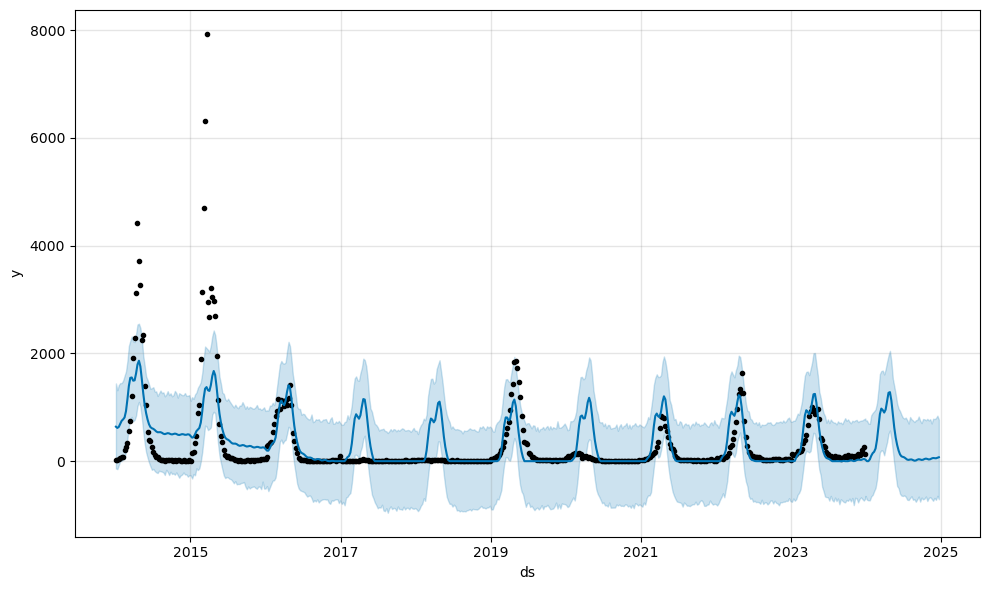

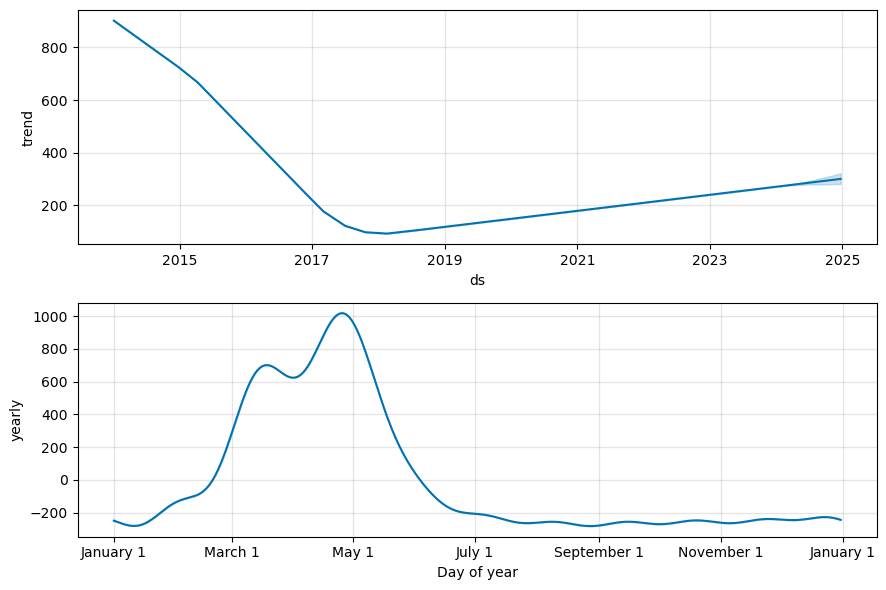

In [43]:
# Prediction without any other features as regressors

df = pd.DataFrame(columns=['ds', 'y'])
df['ds'] = df_2014_2023.index
df['y'] = df_2014_2023['Cases'].values

# Create and fit the model
model = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=False,
    daily_seasonality=False,  # Adjust based on your data frequency
    seasonality_mode='additive'  # Try both 'additive' and 'multiplicative'
)

# Fit the model
model.fit(df)



# Create future dataframe for predictions
future = model.make_future_dataframe(periods=52, freq='W')  # Predict 52 weeks ahead

def clip_predictions(predictions):
    return np.maximum(predictions, 0)

# Make predictions
forecast = model.predict(future)
forecast['yhat'] = clip_predictions(forecast['yhat'])

# Evaluate the model (using the last 52 weeks as a test set)
test_period = 52
y_true = df['y'].iloc[-test_period:]
y_pred = forecast['yhat'].iloc[-test_period:]

mse = mean_squared_error(y_true, y_pred)
mae = mean_absolute_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

print(f"MSE: {mse}")
print(f"MAE: {mae}")
print(f"R2: {r2}")

# Plot the results
fig = model.plot(forecast)
fig.show()

# Plot the components (trend, yearly seasonality, etc.)
fig = model.plot_components(forecast)
fig.show()

In [44]:
df_cv = cross_validation(model, initial='1825 days', period='90 days', horizon='365 days', parallel='threads')
df_cv['yhat'] = clip_predictions(df_cv['yhat'])
df_p = performance_metrics(df_cv, rolling_window=1)

17:10:30 - cmdstanpy - INFO - Chain [1] start processing
17:10:30 - cmdstanpy - INFO - Chain [1] done processing
17:10:30 - cmdstanpy - INFO - Chain [1] start processing
17:10:30 - cmdstanpy - INFO - Chain [1] start processing
17:10:30 - cmdstanpy - INFO - Chain [1] start processing
17:10:30 - cmdstanpy - INFO - Chain [1] start processing
17:10:30 - cmdstanpy - INFO - Chain [1] start processing
17:10:30 - cmdstanpy - INFO - Chain [1] start processing
17:10:30 - cmdstanpy - INFO - Chain [1] start processing
17:10:30 - cmdstanpy - INFO - Chain [1] start processing
17:10:30 - cmdstanpy - INFO - Chain [1] start processing
17:10:30 - cmdstanpy - INFO - Chain [1] start processing
17:10:30 - cmdstanpy - INFO - Chain [1] start processing
17:10:30 - cmdstanpy - INFO - Chain [1] start processing
17:10:30 - cmdstanpy - INFO - Chain [1] start processing
17:10:30 - cmdstanpy - INFO - Chain [1] done processing
17:10:30 - cmdstanpy - INFO - Chain [1] start processing
17:10:30 - cmdstanpy - INFO - Cha

In [44]:
df_p

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,365 days,123243.844898,351.061027,182.976949,2.75043,1.0,1.554046,0.952218


In [45]:
np.where(y_pred<0)

(array([], dtype=int64),)

In [46]:
y_pred.iloc[2]

0.0

### Prediction using the all features as regressors

11:44:44 - cmdstanpy - INFO - Chain [1] start processing
11:44:44 - cmdstanpy - INFO - Chain [1] done processing
11:44:44 - cmdstanpy - INFO - Chain [1] start processing
11:44:44 - cmdstanpy - INFO - Chain [1] done processing
/tmp/ipykernel_77129/1948005336.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  empty_future[col] = regressor_predictions['yhat'].values
11:44:44 - cmdstanpy - INFO - Chain [1] start processing
11:44:44 - cmdstanpy - INFO - Chain [1] done processing
/tmp/ipykernel_77129/1948005336.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user

MSE: 47417.06779420198
MAE: 174.78686575484184
R2: 0.45325602278991484


/tmp/ipykernel_77129/1948005336.py:78: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


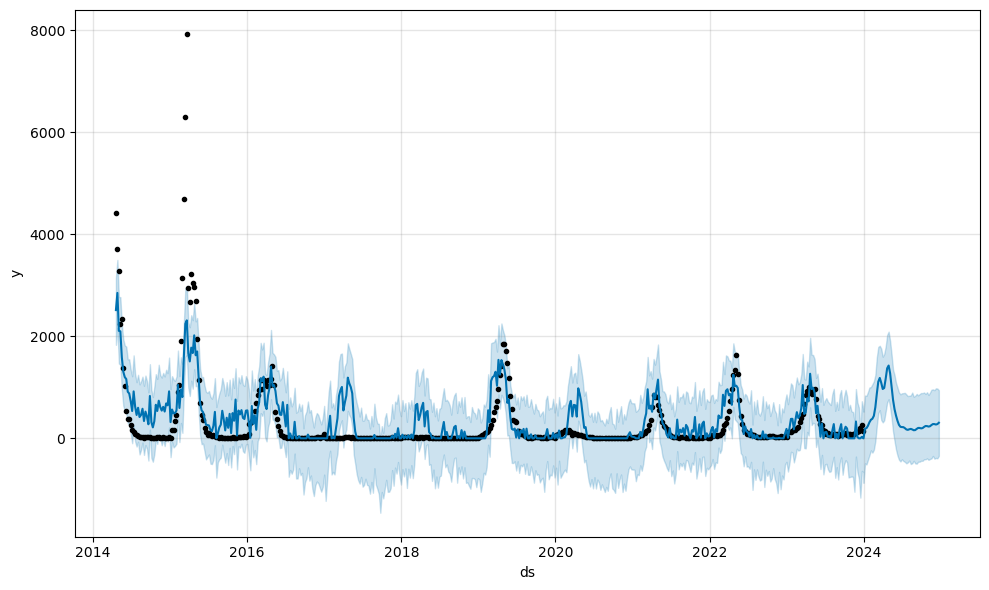

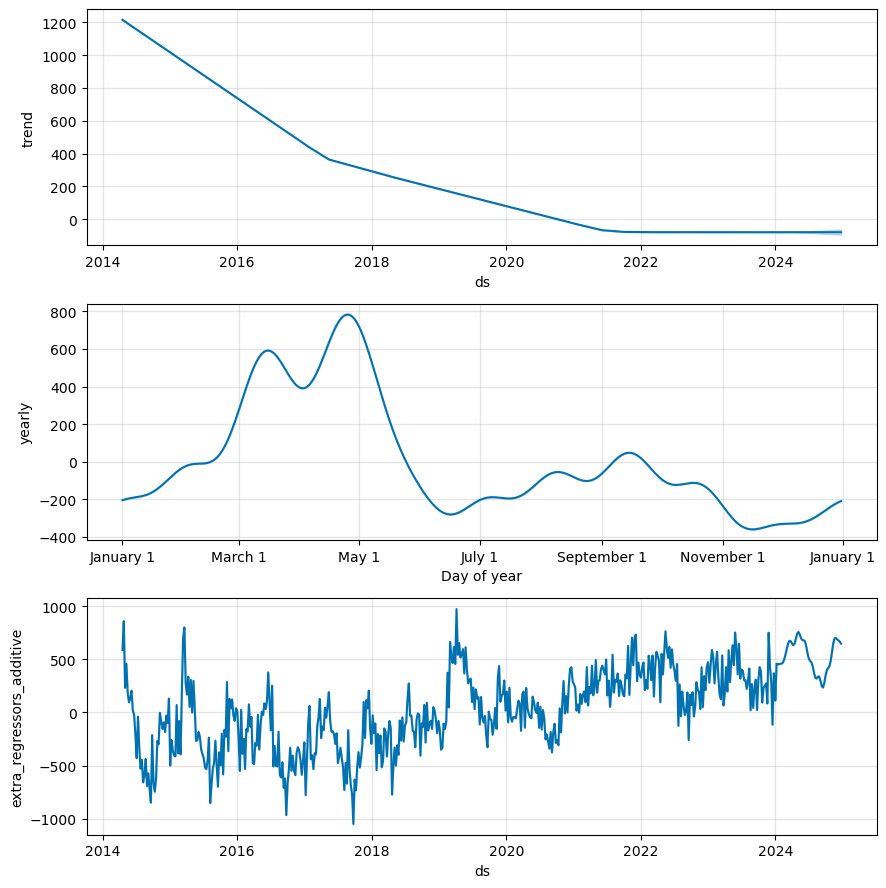

In [47]:

df = pd.DataFrame(columns=['ds', 'y'])
df['ds'] = X.index
df['y'] = y.values

# Create and fit the model
model = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=False,
    daily_seasonality=False,  # Adjust based on your data frequency
    seasonality_mode='additive'  # Try both 'additive' and 'multiplicative'
)

df = pd.concat([df, X.reset_index(drop=True)], axis=1)



# Add extra regressors (your other features)
for column in X.columns:  # Add your actual feature names
    # if column in df.columns:
    model.add_regressor(column)

# Fit the model
model.fit(df)

# Create future dataframe for predictions
future = model.make_future_dataframe(periods=52, freq='W')  # Predict 52 weeks ahead
# Make sure to add your extra regressors to the future dataframe as well

future = pd.concat([future, df.drop('ds', axis=1)], axis=1)

empty_future = future[future.isna().any(axis=1)]
only_future = empty_future[['ds']]

def clip_predictions(predictions):
    return np.maximum(predictions, 0)

# Create a dictionary to hold the different independent variable forecasts 
for col in X.columns:
    # Prep a new training dataset
    train = df[['ds',col]]
    train.columns = ['ds','y'] # rename the variables so they can be submitted to the prophet model

    # Train a model for this regressor 
    rmodel = Prophet()
    rmodel.weekly_seasonality = False # this is specific to my case
    rmodel.fit(train)
    regressor_predictions = rmodel.predict(only_future)
    regressor_predictions['yhat'] = clip_predictions(regressor_predictions['yhat']) # Avoid negative predictions
    # Replace the empty values in the empty dataset with the predicted values from the regressor model 
    empty_future[col] = regressor_predictions['yhat'].values
    
# Fill in the values for all regressors in the future_w_regressors dataset 
future.loc[future.isnull().any(axis=1)] = empty_future.values

# Make predictions
forecast = model.predict(future)
forecast['yhat'] = clip_predictions(forecast['yhat'])

# Evaluate the model (using the last 52 weeks as a test set)
test_period = 52
y_true = df['y'].iloc[-test_period:]
y_pred = forecast['yhat'].iloc[-test_period:]

mse = mean_squared_error(y_true, y_pred)
mae = mean_absolute_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

print(f"MSE: {mse}")
print(f"MAE: {mae}")
print(f"R2: {r2}")

# Plot the results
fig = model.plot(forecast)
fig.show()

# Plot the components (trend, yearly seasonality, etc.)
fig = model.plot_components(forecast)
fig.show()

### Prediction using the features selected by the ensemble point system as regressors

11:09:07 - cmdstanpy - INFO - Chain [1] start processing
11:09:07 - cmdstanpy - INFO - Chain [1] done processing
11:09:07 - cmdstanpy - INFO - Chain [1] start processing
11:09:07 - cmdstanpy - INFO - Chain [1] done processing
/tmp/ipykernel_23010/3850761978.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  empty_future[col] = regressor_predictions['yhat'].values
11:09:07 - cmdstanpy - INFO - Chain [1] start processing
11:09:07 - cmdstanpy - INFO - Chain [1] done processing
/tmp/ipykernel_23010/3850761978.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user

MSE: 22439.522571139238
MAE: 88.04905180242253
R2: 0.7412603860177891


/tmp/ipykernel_23010/3850761978.py:76: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


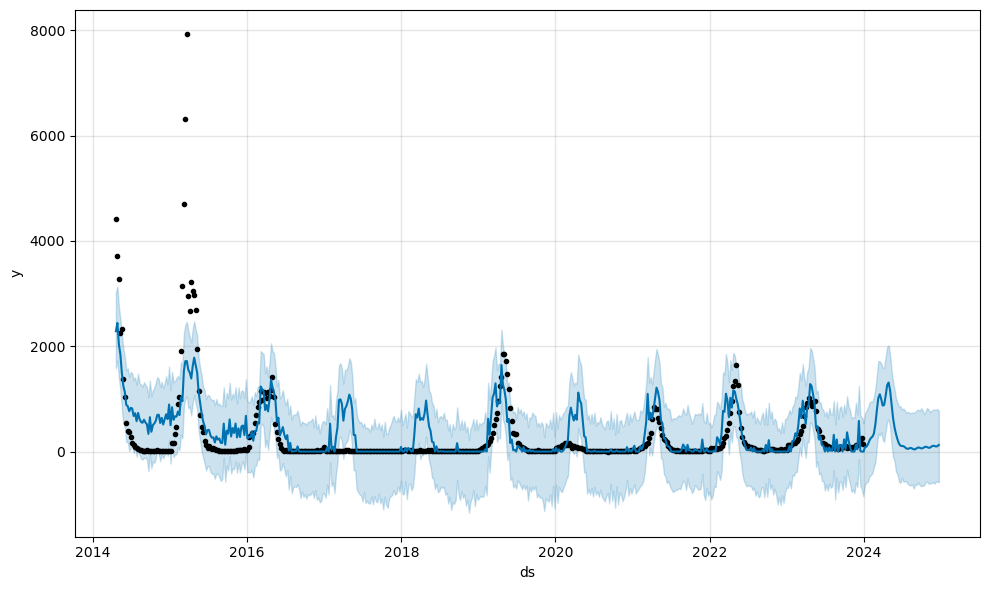

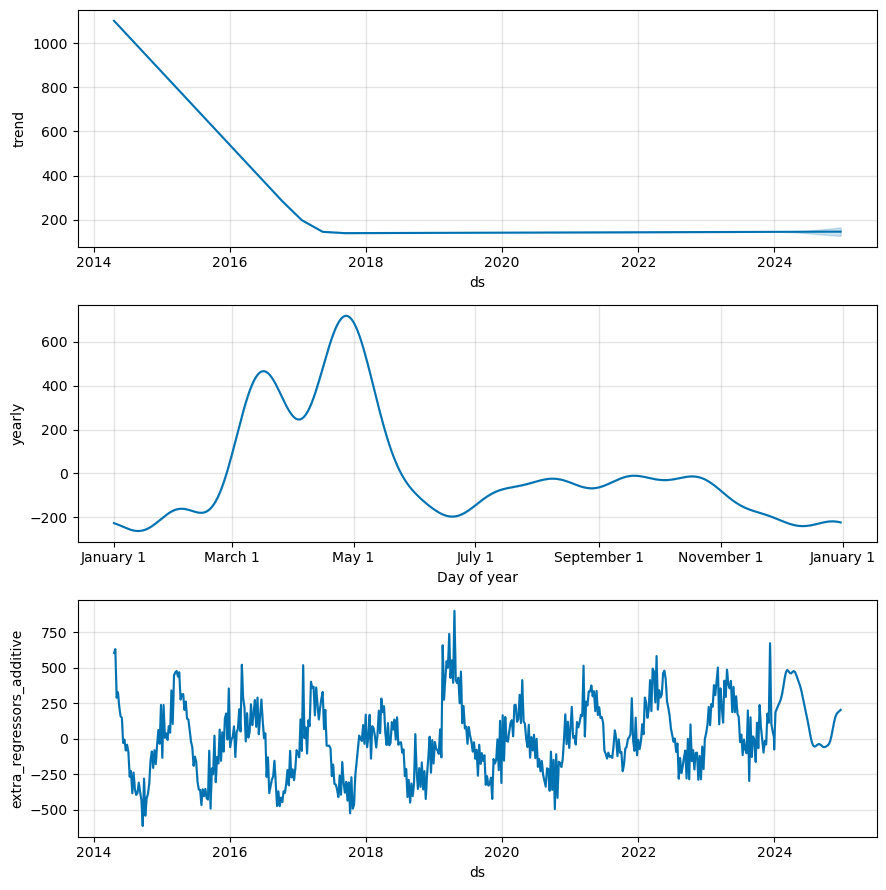

In [48]:

df = pd.DataFrame(columns=['ds', 'y'])
df['ds'] = X.index
df['y'] = y.values

# Create and fit the model
model = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=False,
    daily_seasonality=False,  # Adjust based on your data frequency
    seasonality_mode='additive'  # Try both 'additive' and 'multiplicative'
)

df = pd.concat([df, X[ensemble_features].reset_index(drop=True)], axis=1)

# Add extra regressors (your other features)
for column in X[ensemble_features].columns:  # Add your actual feature names
    # if column in df.columns:
    model.add_regressor(column)

# Fit the model
model.fit(df)

# Create future dataframe for predictions
future = model.make_future_dataframe(periods=52, freq='W')  # Predict 52 weeks ahead
# Make sure to add your extra regressors to the future dataframe as well

future = pd.concat([future, df.drop('ds', axis=1)], axis=1)

empty_future = future[future.isna().any(axis=1)]
only_future = empty_future[['ds']]

def clip_predictions(predictions):
    return np.maximum(predictions, 0)

# Create a dictionary to hold the different independent variable forecasts 
for col in ensemble_features:
    # Prep a new training dataset
    train = df[['ds',col]]
    train.columns = ['ds','y'] # rename the variables so they can be submitted to the prophet model

    # Train a model for this regressor 
    rmodel = Prophet()
    rmodel.weekly_seasonality = False # this is specific to my case
    rmodel.fit(train)
    regressor_predictions = rmodel.predict(only_future)
    regressor_predictions['yhat'] = clip_predictions(regressor_predictions['yhat'])
    # Replace the empty values in the empty dataset with the predicted values from the regressor model 
    empty_future[col] = regressor_predictions['yhat'].values
    
# Fill in the values for all regressors in the future_w_regressors dataset 
future.loc[future.isnull().any(axis=1)] = empty_future.values

# Make predictions
forecast = model.predict(future)
forecast['yhat'] = clip_predictions(forecast['yhat'])

# Evaluate the model (using the last 52 weeks as a test set)
test_period = 52
y_true = df['y'].iloc[-test_period:]
y_pred = forecast['yhat'].iloc[-test_period:]

mse = mean_squared_error(y_true, y_pred)
mae = mean_absolute_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

print(f"MSE: {mse}")
print(f"MAE: {mae}")
print(f"R2: {r2}")

# Plot the results
fig = model.plot(forecast)
fig.show()

# Plot the components (trend, yearly seasonality, etc.)
fig = model.plot_components(forecast)
fig.show()

### Prediction using the features selected by boruta

In [ ]:

df = pd.DataFrame(columns=['ds', 'y'])
df['ds'] = X.index
df['y'] = y.values

# Create and fit the model
model_boruta_features = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=False,
    daily_seasonality=False,  # Adjust based on your data frequency
    seasonality_mode='additive'  # Try both 'additive' and 'multiplicative'
)

df = pd.concat([df, X[boruta_features].reset_index(drop=True)], axis=1)

# Add extra regressors (your other features)
for column in X[boruta_features].columns:  # Add your actual feature names
    # if column in df.columns:
    model_boruta_features.add_regressor(column)  # Add the feature to the model

# Fit the model
model.fit(df)

# Create future dataframe for predictions
future = model.make_future_dataframe(periods=52, freq='W')  # Predict 52 weeks ahead
# Make sure to add your extra regressors to the future dataframe as well

future = pd.concat([future, df.drop('ds', axis=1)], axis=1)

empty_future = future[future.isna().any(axis=1)]
only_future = empty_future[['ds']]

def clip_predictions(predictions):
    return np.maximum(predictions, 0)

# Create a dictionary to hold the different independent variable forecasts 
for col in boruta_features:
    # Prep a new training dataset
    train = df[['ds',col]]
    train.columns = ['ds','y'] # rename the variables so they can be submitted to the prophet model

    # Train a model for this regressor 
    rmodel = Prophet()
    rmodel.weekly_seasonality = False # this is specific to my case
    rmodel.fit(train)
    regressor_predictions = rmodel.predict(only_future)
    regressor_predictions['yhat'] = clip_predictions(regressor_predictions['yhat'])
    # Replace the empty values in the empty dataset with the predicted values from the regressor model 
    empty_future[col] = regressor_predictions['yhat'].values
    
# Fill in the values for all regressors in the future_w_regressors dataset 
future.loc[future.isnull().any(axis=1)] = empty_future.values

# Make predictions
forecast = model.predict(future)
forecast['yhat'] = clip_predictions(forecast['yhat'])

# Evaluate the model (using the last 52 weeks as a test set)
test_period = 52
y_true = df['y'].iloc[-test_period:]
y_pred = forecast['yhat'].iloc[-test_period:]

mse = mean_squared_error(y_true, y_pred)
mae = mean_absolute_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

print(f"MSE: {mse}")
print(f"MAE: {mae}")
print(f"R2: {r2}")

# Plot the results
fig = model.plot(forecast)
fig.show()

# Plot the components (trend, yearly seasonality, etc.)
fig = model.plot_components(forecast)
fig.show()

17:11:06 - cmdstanpy - INFO - Chain [1] start processing


17:11:06 - cmdstanpy - INFO - Chain [1] done processing
17:11:06 - cmdstanpy - INFO - Chain [1] start processing
17:11:06 - cmdstanpy - INFO - Chain [1] start processing
17:11:06 - cmdstanpy - INFO - Chain [1] start processing
17:11:06 - cmdstanpy - INFO - Chain [1] start processing
17:11:06 - cmdstanpy - INFO - Chain [1] start processing
17:11:06 - cmdstanpy - INFO - Chain [1] start processing
17:11:06 - cmdstanpy - INFO - Chain [1] start processing
17:11:06 - cmdstanpy - INFO - Chain [1] start processing
17:11:06 - cmdstanpy - INFO - Chain [1] start processing
17:11:06 - cmdstanpy - INFO - Chain [1] start processing
17:11:06 - cmdstanpy - INFO - Chain [1] start processing
17:11:06 - cmdstanpy - INFO - Chain [1] start processing
17:11:06 - cmdstanpy - INFO - Chain [1] start processing
17:11:06 - cmdstanpy - INFO - Chain [1] start processing
17:11:06 - cmdstanpy - INFO - Chain [1] start processing
17:11:06 - cmdstanpy - INFO - Chain [1] done processing
17:11:06 - cmdstanpy - INFO - Cha

               Model            MSE         MAE      MAPE
0        no_features  144363.613179  199.082643  3.532946
1       all_features  108837.991982  209.557704  4.623694
2  ensemble_features   95110.862748  163.013311  2.058950
3    boruta_features  109973.772317  171.970698  2.689608

Best model: ensemble_features


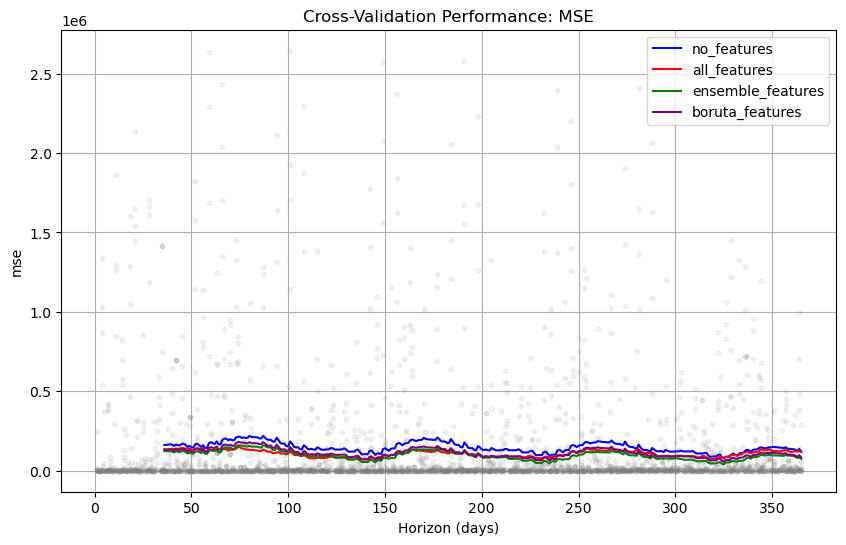

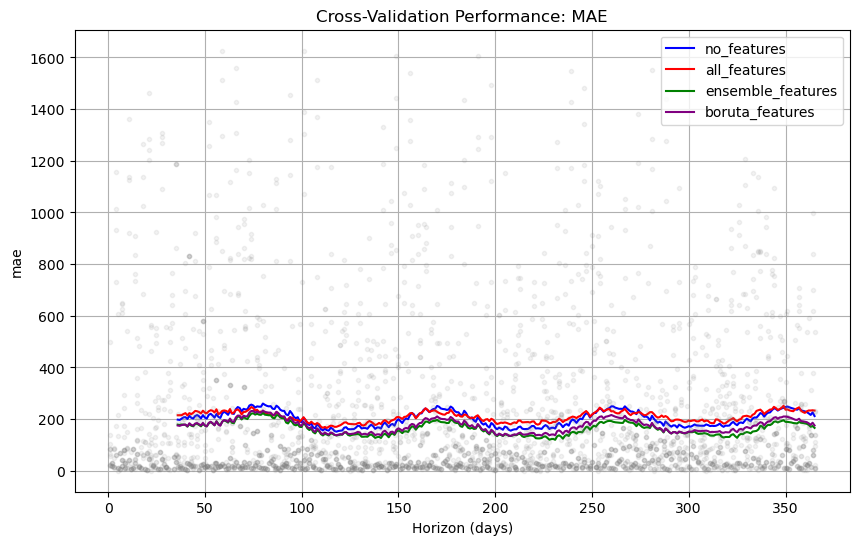

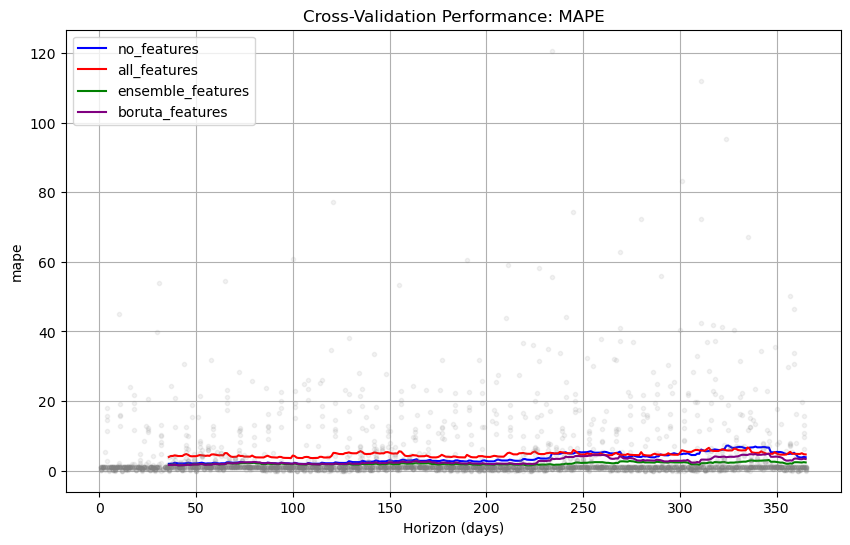

In [45]:
from prophet.plot import plot_cross_validation_metric
import pandas as pd
import numpy as np
from prophet import Prophet
from prophet.diagnostics import cross_validation

def clip_predictions(predictions):
    return np.maximum(predictions, 0)

def prophet_cv_with_features(model, X, y, feature_set=[], initial='1825 days', period='90 days', horizon='365 days'):
    """
    Performs cross-validation on a Prophet model with specified features.

    Args:
        model: The Prophet model.
        X: The DataFrame containing all features.
        y: The target variable.
        feature_set: The list of features to use as regressors.
        initial: The initial training period for each fold.
        period: The period of the rolling window for each fold.
        horizon: The prediction horizon for each fold.

    Returns:
        A DataFrame containing the cross-validation results.
    """
    df = pd.DataFrame(columns=['ds', 'y'])
    df['ds'] = X.index
    df['y'] = y.values

    # Add extra regressors (your other features)
    df = pd.concat([df, X[feature_set].reset_index(drop=True)], axis=1)

    # **CHANGE 1: Create a new Prophet model instance inside the function**
    model = Prophet(
        yearly_seasonality=True,
        weekly_seasonality=False,
        daily_seasonality=False,  # Adjust based on your data frequency
        seasonality_mode='additive'  # Try both 'additive' and 'multiplicative'
    )

    # **CHANGE 2: Add regressors before fitting the model**
    for column in feature_set:
        model.add_regressor(column)

    # Fit the model
    model.fit(df)

    # Create future dataframe for predictions
    future = model.make_future_dataframe(periods=52, freq='W')  # Predict 52 weeks ahead
    # Make sure to add your extra regressors to the future dataframe as well

    future = pd.concat([future, df.drop('ds', axis=1)], axis=1)

    empty_future = future[future.isna().any(axis=1)]
    only_future = empty_future[['ds']]

    # Create a dictionary to hold the different independent variable forecasts 
    for col in feature_set:
        # Prep a new training dataset
        train = df[['ds',col]]
        train.columns = ['ds','y'] # rename the variables so they can be submitted to the prophet model

        # Train a model for this regressor 
        rmodel = Prophet()
        rmodel.fit(train)
        regressor_predictions = rmodel.predict(only_future)
        regressor_predictions['yhat'] = clip_predictions(regressor_predictions['yhat'])
        # Replace the empty values in the empty dataset with the predicted values from the regressor model 
        empty_future[col] = regressor_predictions['yhat'].values
        
        # Fill in the values for all regressors in the future_w_regressors dataset 
        future.loc[future.isnull().any(axis=1)] = empty_future.values

    # Perform cross-validation
    df_cv = cross_validation(
        model,
        initial=initial,
        period=period,
        horizon=horizon,
        parallel='threads',
    )
    df_cv['yhat'] = clip_predictions(df_cv['yhat'])
    return df_cv

model = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=False,
    daily_seasonality=False,  # Adjust based on your data frequency
    seasonality_mode='additive'  # Try both 'additive' and 'multiplicative'
)

# Cross-validation results for each model
cv_results = {}

# No features
cv_results['no_features'] = prophet_cv_with_features(model, X, y, [])

# All features
cv_results['all_features'] = prophet_cv_with_features(model, X, y, X.columns.tolist())

# Ensemble features
cv_results['ensemble_features'] = prophet_cv_with_features(model, X, y, ensemble_features)

# Boruta features
cv_results['boruta_features'] = prophet_cv_with_features(model, X, y, boruta_features)

# Evaluate and compare performance
performance_metrics_df = pd.DataFrame(columns=['Model', 'MSE', 'MAE', 'MAPE'])

for model_name, cv_result in cv_results.items():
    df_p = performance_metrics(cv_result, rolling_window=1)
    new_row = pd.DataFrame(
        {
            'Model': [model_name],
            'MSE': [df_p['mse'].iloc[0]],  # Use iloc instead of values
            'MAE': [df_p['mae'].iloc[0]],  # Use iloc instead of values
            'MAPE': [df_p['mape'].iloc[0]],  # Use iloc instead of values
        }
    )
    performance_metrics_df = pd.concat(
        [performance_metrics_df, new_row], ignore_index=True
    )

print(performance_metrics_df)

# Select the best model based on MAPE
best_model_name = performance_metrics_df.loc[performance_metrics_df['MAPE'].idxmin()]['Model']
print(f"\nBest model: {best_model_name}")

# Visualize performance comparison
metrics = ['mse', 'mae', 'mape']
colors = {
    'no_features': 'blue',
    'all_features': 'red',
    'ensemble_features': 'green',
    'boruta_features': 'purple',
}

for metric in metrics:
    fig = plt.figure(figsize=(10, 6))  # Adjust figure size as needed
    ax = plt.gca()  # Get the current axes
    for model_name, cv_result in cv_results.items():
        plot_cross_validation_metric(cv_result, metric=metric, ax=ax, color=colors[model_name])
        # Manually add labels after plotting
        ax.lines[-1].set_label(model_name)
    plt.title(f'Cross-Validation Performance: {metric.upper()}')
    plt.legend()
    plt.show()

for i, metric in enumerate(metrics):
    for model_name in cv_results.keys():
        df_p = performance_metrics(cv_results[model_name], rolling_window=1)


### Predicting 2024 values

In [63]:
def predict_cases(X, y, feature_set):
    df = pd.DataFrame(columns=['ds', 'y'])
    df['ds'] = X.index
    df['y'] = y.values

    # Add extra regressors (your other features)
    df = pd.concat([df, X[feature_set].reset_index(drop=True)], axis=1)

    # **CHANGE 1: Create a new Prophet model instance inside the function**
    model = Prophet(
        yearly_seasonality=True,
        weekly_seasonality=False,
        daily_seasonality=False,  # Adjust based on your data frequency
        seasonality_mode='additive'  # Try both 'additive' and 'multiplicative'
    )

    # **CHANGE 2: Add regressors before fitting the model**
    for column in feature_set:
        model.add_regressor(column)

    # Fit the model
    model.fit(df)

    # Create future dataframe for predictions
    future = model.make_future_dataframe(periods=52, freq='W')  # Predict 52 weeks ahead
    # Make sure to add your extra regressors to the future dataframe as well

    future = pd.concat([future, df.drop('ds', axis=1)], axis=1)

    empty_future = future[future.isna().any(axis=1)]
    only_future = empty_future[['ds']]

    # Create a dictionary to hold the different independent variable forecasts 
    for col in feature_set:
        # Prep a new training dataset
        train = df[['ds',col]]
        train.columns = ['ds','y'] # rename the variables so they can be submitted to the prophet model

        # Train a model for this regressor 
        rmodel = Prophet()
        rmodel.fit(train)
        regressor_predictions = rmodel.predict(only_future)
        regressor_predictions['yhat'] = clip_predictions(regressor_predictions['yhat'])
        # Replace the empty values in the empty dataset with the predicted values from the regressor model 
        empty_future[col] = regressor_predictions['yhat'].values
        
        # Fill in the values for all regressors in the future_w_regressors dataset 
        future.loc[future.isnull().any(axis=1)] = empty_future.values

    # Make predictions
    forecast = model.predict(future)
    forecast['yhat'] = clip_predictions(forecast['yhat'])

    # Filter predictions for the first semester of 2024
    forecast_2024_semester1 = forecast[
        (forecast['ds'].dt.year == 2024) & (forecast['ds'].dt.month <= 6)
    ]

    return forecast_2024_semester1[['ds', 'yhat']]

In [71]:
cases = predict_cases(X, y, ensemble_features)

20:01:52 - cmdstanpy - INFO - Chain [1] start processing
20:01:52 - cmdstanpy - INFO - Chain [1] done processing
20:01:52 - cmdstanpy - INFO - Chain [1] start processing
20:01:52 - cmdstanpy - INFO - Chain [1] done processing
20:01:52 - cmdstanpy - INFO - Chain [1] start processing
20:01:52 - cmdstanpy - INFO - Chain [1] done processing
20:01:52 - cmdstanpy - INFO - Chain [1] start processing
20:01:52 - cmdstanpy - INFO - Chain [1] done processing
20:01:52 - cmdstanpy - INFO - Chain [1] start processing
20:01:52 - cmdstanpy - INFO - Chain [1] done processing
20:01:52 - cmdstanpy - INFO - Chain [1] start processing
20:01:52 - cmdstanpy - INFO - Chain [1] done processing
20:01:52 - cmdstanpy - INFO - Chain [1] start processing
20:01:52 - cmdstanpy - INFO - Chain [1] done processing
20:01:52 - cmdstanpy - INFO - Chain [1] start processing
20:01:52 - cmdstanpy - INFO - Chain [1] done processing
20:01:52 - cmdstanpy - INFO - Chain [1] start processing
20:01:52 - cmdstanpy - INFO - Chain [1]

In [72]:
cases

,ds,yhat
506,2024-01-07,85.802696
507,2024-01-14,92.355060
508,2024-01-21,138.301684
509,2024-01-28,208.599140
510,2024-02-04,259.037841
511,2024-02-11,281.872050
512,2024-02-18,340.166780
513,2024-02-25,509.351512
514,2024-03-03,775.956861
515,2024-03-10,1013.842035


Length of actual_cases_2024: 26
Length of cases['yhat']: 26
MSE for 2024: 769345541.2069632
MAE for 2024: 21789.38890462933
R2 for 2024: -1.5066943259214862


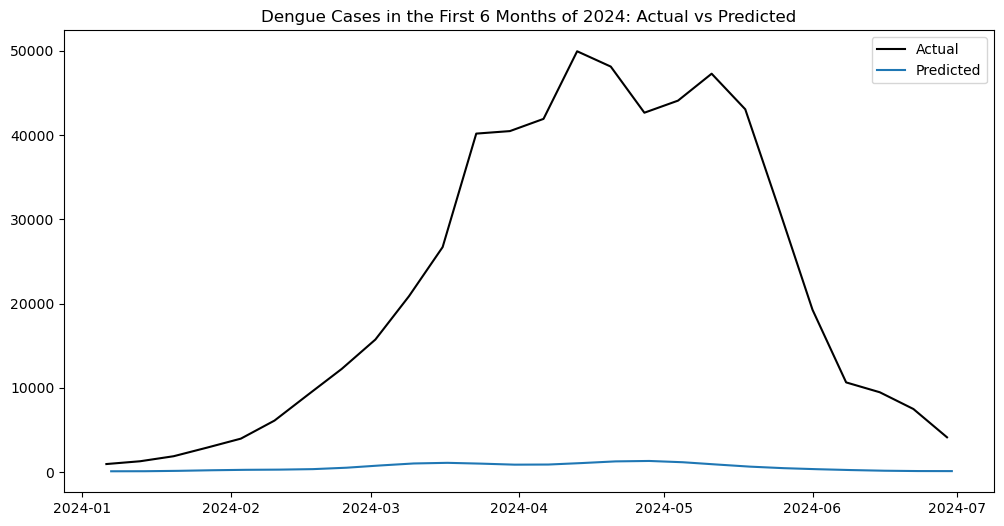

In [73]:
# Get actual dengue cases for the first 6 months of 2024
actual_cases_2024 = df_2024['Cases'].iloc[:26]

print(f"Length of actual_cases_2024: {len(actual_cases_2024)}")
print(f"Length of cases['yhat']: {len(cases['yhat'])}")

# Evaluate the predictions
mse = mean_squared_error(actual_cases_2024, cases['yhat'])
mae = mean_absolute_error(actual_cases_2024, cases['yhat'])
r2 = r2_score(actual_cases_2024, cases['yhat'])

print(f"MSE for 2024: {mse}")
print(f"MAE for 2024: {mae}")
print(f"R2 for 2024: {r2}")

# Visualize the predictions against actual values
plt.figure(figsize=(12, 6))
plt.plot(actual_cases_2024.index, actual_cases_2024, label='Actual', color='black')
plt.plot(cases['ds'], cases['yhat'], label='Predicted')
plt.title('Dengue Cases in the First 6 Months of 2024: Actual vs Predicted')
plt.legend()
plt.show()

Still needs more testing using other models (work in progress)